In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [2]:
with open('data/train.jsonl') as f:
    train_data = pd.read_json(f, lines=True)

In [3]:
train_data.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [4]:
with open('data/test.jsonl') as f:
    test_data = pd.read_json(f, lines=True)

In [5]:
test_data.head()

,id,response,context
0,twitter_1,"@USER @USER @USER My 3 year old , that just fi...","[Well now that ’ s problematic AF <URL>, @USER..."
1,twitter_2,@USER @USER How many verifiable lies has he to...,[Last week the Fake News said that a section o...
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...,[@USER Let ’ s Aplaud Brett When he deserves i...
3,twitter_4,@USER @USER is just a cover up for the real ha...,[Women generally hate this president . What's ...
4,twitter_5,@USER @USER @USER The irony being that he even...,"[Dear media Remoaners , you excitedly sharing ..."


In [6]:
train_data['label'].value_counts()

SARCASM        2500
NOT_SARCASM    2500
Name: label, dtype: int64

In [7]:
context_length = train_data['context'].apply(len)
print('min messages: {}, max messages: {}'.format(
    context_length.min(),
    context_length.max()))

min messages: 2, max messages: 20


<AxesSubplot:>

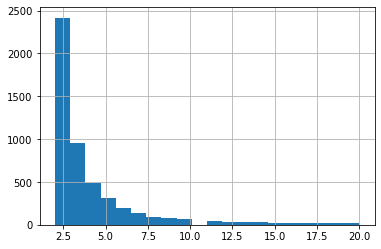

In [8]:
context_length.hist(bins = 20)

In [9]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(train_data['label'])

In [10]:
X = train_data['response'] + ' ' + train_data['context'].str.join(' ')

In [11]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [12]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [13]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn),
          'precision': 'precision',
          'recall': 'recall',
          'f1': 'f1'}
res = cross_validate(text_clf, X, y, cv=skf, n_jobs=5, scoring=scoring)

In [14]:
res

{'fit_time': array([0.48561001, 0.47597289, 0.47986889, 0.48628497, 0.48119497]),
 'score_time': array([0.10172915, 0.10271502, 0.10232115, 0.09331012, 0.10188079]),
 'test_tp': array([378, 387, 385, 386, 416]),
 'test_tn': array([360, 381, 345, 348, 361]),
 'test_fp': array([140, 119, 155, 152, 139]),
 'test_fn': array([122, 113, 115, 114,  84]),
 'test_precision': array([0.72972973, 0.76482213, 0.71296296, 0.71747212, 0.74954955]),
 'test_recall': array([0.756, 0.774, 0.77 , 0.772, 0.832]),
 'test_f1': array([0.74263261, 0.7693837 , 0.74038462, 0.74373796, 0.78862559])}

In [15]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res['test_precision']), np.average(res['test_recall']), np.average(res['test_f1'])))

Macro Avg precision: 0.7349072991177403, recall 0.7807999999999999, F1 score 0.7569528952384379


In [16]:
final_model = text_clf.fit(X, y)
test_res = final_model.predict(test_data['response'] + ' ' + test_data['context'].str.join(' '))

In [17]:
result_df = pd.DataFrame()
result_df['id'] = test_data['id']
result_df['result'] = pd.Series(le.inverse_transform(test_res))

In [18]:
result_df.head()

,id,result
0,twitter_1,NOT_SARCASM
1,twitter_2,SARCASM
2,twitter_3,NOT_SARCASM
3,twitter_4,NOT_SARCASM
4,twitter_5,SARCASM


In [19]:
with open('answer.txt', 'w') as f:
    result_df.to_csv(f, header=False, index=False)

In [20]:
result_df['result'].value_counts()

SARCASM        904
NOT_SARCASM    896
Name: result, dtype: int64

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
text_clf2 = Pipeline([
    ('vect', CountVectorizer(strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)),
    ('tfidf', TfidfTransformer()),
    ('clf', GradientBoostingClassifier()),
])
res2 = cross_validate(text_clf2, X, y, cv=skf, n_jobs=5, scoring=scoring)

In [ ]:
res2

In [ ]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res2['test_precision']), np.average(res2['test_recall']), np.average(res2['test_f1'])))

In [21]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res2['test_precision']), np.average(res2['test_recall']), np.average(res2['test_f1'])))

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
text_clf2 = Pipeline([
    ('vect', CountVectorizer(strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)),
    ('tfidf', TfidfTransformer()),
    ('clf', GradientBoostingClassifier()),
])
res2 = cross_validate(text_clf2, X, y, cv=skf, n_jobs=5, scoring=scoring)

In [32]:
res2

{'fit_time': array([4.81338787, 4.79871988, 4.79757595, 4.80710602, 4.77047992]),
 'score_time': array([0.11284304, 0.11582422, 0.11988115, 0.12483907, 0.12236404]),
 'test_tp': array([372, 384, 377, 399, 390]),
 'test_tn': array([284, 303, 298, 290, 318]),
 'test_fp': array([216, 197, 202, 210, 182]),
 'test_fn': array([128, 116, 123, 101, 110]),
 'test_precision': array([0.63265306, 0.66092943, 0.65112263, 0.65517241, 0.68181818]),
 'test_recall': array([0.744, 0.768, 0.754, 0.798, 0.78 ]),
 'test_f1': array([0.68382353, 0.71045328, 0.69879518, 0.71956718, 0.72761194])}

In [33]:
print('Macro Avg precision: {}, recall {}, F1 score {}'.format(np.average(res2['test_precision']), np.average(res2['test_recall']), np.average(res2['test_f1'])))

Macro Avg precision: 0.6563391428130868, recall 0.7688, F1 score 0.708050222413395
